<a href="https://colab.research.google.com/github/Alazar10/Projects-/blob/main/Model_Subclassing_and_Custom_Layer_(Malaria_Detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf ### Models
import matplotlib.pyplot as plt ### Plotting Bar Chart
import numpy as np ### Maths Computations
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt

In [3]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteS7QNYG/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):

    DATA_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO * DATA_SIZE))


    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATA_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATA_SIZE))


    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATA_SIZE))

    return train_dataset, val_dataset, test_dataset

In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

#dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))


[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

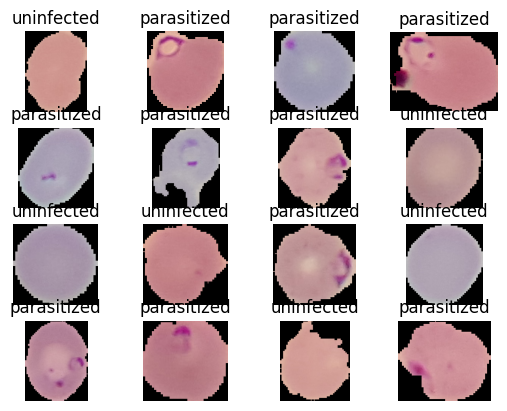

In [6]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [7]:
dataset_info.features['label'].int2str(1)

'uninfected'

In [8]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image,(IM_SIZE, IM_SIZE))/255.0, label

In [9]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [10]:
for image,label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [11]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
val_dataset =  val_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
Model1 = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),

    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    Dense(100, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid')
])
Model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

**Functional API**

In [13]:
func_input = Input(shape = (IM_SIZE,IM_SIZE,3), name = " Input_Image ")

x= Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x =  BatchNormalization()(x)
output =  MaxPool2D(pool_size = 2, strides = 2)(x)

Feature_Extractor_Model = Model(func_input, output, name = "Feature_Extractor")
Feature_Extractor_Model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
  Input_Image  (InputLayer)  [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)

In [14]:
func_input = Input(shape = (IM_SIZE,IM_SIZE,3), name = " Input_Image ")

x = Feature_Extractor_Model(func_input)

x =  Flatten()(x)

x =  Dense(100, activation = 'relu')(x)
x =  BatchNormalization()(x)
x  = Dense(10, activation = 'relu')(x)
x =  BatchNormalization()(x)
func_output =  Dense(1, activation = 'sigmoid')(x)

Model2 = Model(func_input, func_output, name = "Model2")
Model2.summary()

Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
  Input_Image  (InputLayer)  [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_6 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                1010 

**Model SubClassing**

In [26]:
class Model_Subclassing(Layer):
  def __init__(self):
    super().__init__()

    self.conv_1 = Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size = 2, strides = 2)

    self.conv_2 = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size = 2, strides = 2)

  def call(self, x):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)
    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_subclassed = Model_Subclassing()



In [28]:
class Model3_subclassed(Model):
  def __init__(self):
    super().__init__()

    self.feature_extractor = feature_subclassed
    self.flatten = Flatten()
    self.Dense_1 = Dense(100, activation = 'relu')
    self.batch_3 = BatchNormalization()

    self.Dense_2 = Dense(10, activation = 'relu')
    self.batch_4 = BatchNormalization()

    self.Dense_3 = Dense(1, activation = 'sigmoid')

  def call(self, x):

    x = self.feature_extractor(x)

    x = self.flatten(x)
    x = self.Dense_1(x)
    x = self.batch_3(x)

    x = self.Dense_2(x)
    x = self.batch_4(x)

    x = self.Dense_3(x)

    return x

Model3 = Model3_subclassed()
Model3(tf.zeros([1,224,224,3]))
Model3.summary()


Model: "model3_subclassed_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model__subclassing (Model_  multiple                  1136      
 Subclassing)                                                    
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_12 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_13 (Ba  multiple          

**Custom Layer**

In [17]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()

    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_Shape):
    self.w = self.add_weight(shape = (input_features_Shape[-1], self.output_units), initializer = "random_normal", trainable = True)
    self.b = self.add_weight(shape = (self.output_units, ), initializer = "random_normal", trainable = True)

  def call(self, input_features):

    pre_output = tf.matmul(input_features, self.w) + self.b
    if (self.activation == "relu"):
      return tf.nn.relu(pre_output)
    elif (self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output




In [18]:
Model4 = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),

    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    NeuralearnDense(100, activation = 'relu'),
    BatchNormalization(),
    NeuralearnDense(10, activation = 'relu'),
    BatchNormalization(),
    NeuralearnDense(1, activation = 'sigmoid')
])
Model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [20]:
Model4.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy')

In [21]:
history=Model4.fit(train_dataset, validation_data=val_dataset,epochs=5, verbose=1)

Epoch 1/5
689/689 [==============================] - 53s 64ms/step - loss: 0.2820 - accuracy: 0.8903 - val_loss: 0.7687 - val_accuracy: 0.8555
Epoch 2/5
689/689 [==============================] - 46s 66ms/step - loss: 0.1894 - accuracy: 0.9379 - val_loss: 0.1871 - val_accuracy: 0.9368
Epoch 3/5
689/689 [==============================] - 43s 62ms/step - loss: 0.1600 - accuracy: 0.9483 - val_loss: 0.5093 - val_accuracy: 0.6029
Epoch 4/5
689/689 [==============================] - 50s 72ms/step - loss: 0.1582 - accuracy: 0.9477 - val_loss: 0.8073 - val_accuracy: 0.5757
Epoch 5/5
689/689 [==============================] - 42s 61ms/step - loss: 0.1445 - accuracy: 0.9535 - val_loss: 0.2364 - val_accuracy: 0.9183


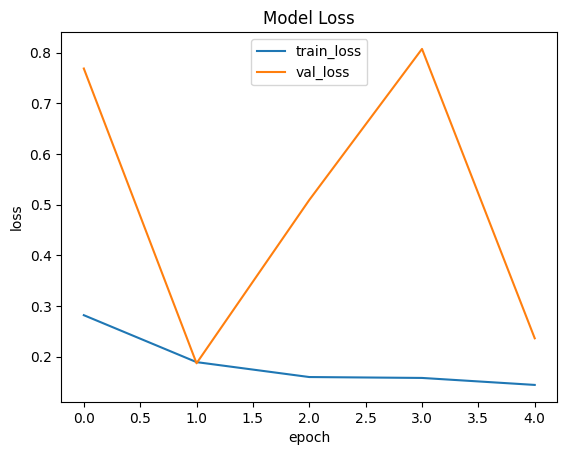

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

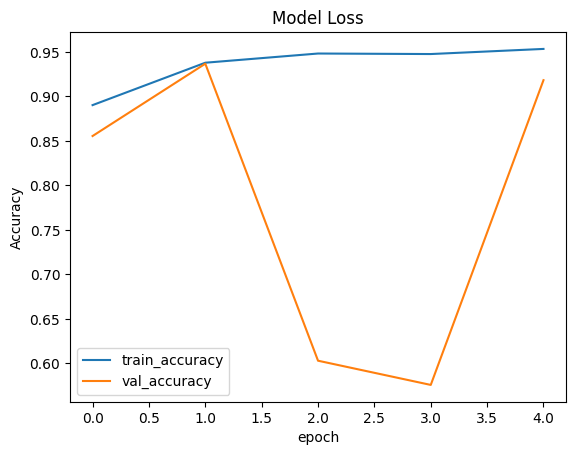

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show

In [24]:
test_dataset = test_dataset.batch(1)

In [25]:
def parasite_or_Not(x):
    if(x<0.5):
        return str('Par')
    else:
        return str('Uni')

In [26]:
Model4.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 12s 12s/step


0.009320274

In [27]:
parasite_or_Not(Model4.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 11s 11s/step


'Uni'

1/1 [==============================] - 0s 18ms/step


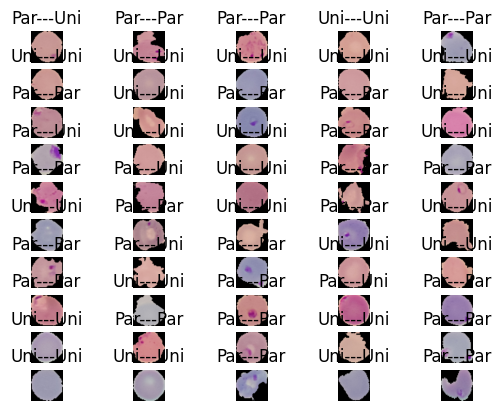

In [28]:
for i, (image, label) in enumerate (test_dataset.take(50)):

    ax = plt.subplot(10, 5, i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_Not(label.numpy()[0])) + "---" + str(parasite_or_Not(Model4.predict(image)[0][0])))
    plt.axis('off')